In [4]:
import pandas as pd
import os
import pickle
from sklearn import preprocessing

# This was generated by last cell of all_at_a_time.ipynb, with 20x20 data points,
# and ggap gsyn ranging from 0.8 to 1.4, which time_series_clustering.ipynb
# claims to be the oscillatory domain.
aat_results_file = "cached_notebook_results/all_at_a_time_results.pkl"
with open(aat_results_file, "rb") as f:
    df = pickle.load(f)


#Need to standardize the parameters for power calculation
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(df[['Ggap', 'Gsyn']])

scaled_df = pd.DataFrame(scaled_df, columns=['Ggap', 'Gsyn'])

df.describe()

,Ggap,Gsyn,dom_amplitude,dom_period,dimensionality
count,400.000000,400.000000,400.000000,400.000000,400.000000
mean,1.100000,1.100000,191.886777,2.053851,1.699147
std,0.182321,0.182321,73.858618,0.148220,0.230720
min,0.800000,0.800000,60.750802,1.996000,1.472867
25%,0.950000,0.950000,132.490610,1.996000,1.576581
50%,1.100000,1.100000,182.547314,1.996000,1.640305
75%,1.250000,1.250000,245.628937,1.996000,1.691744
max,1.400000,1.400000,395.928226,2.495000,2.759382


In [5]:
import dexpy.power as dp

sn = 1.5
alpha = 0.05
model = 'Ggap + Gsyn + Ggap:Gsyn'

design = scaled_df

power = dp.f_power(model, design, sn, alpha)
power.pop(0) # remove intercept
power = ['{0:.2f}%'.format(i*100) for i in power] # convert to %
print(power)

['100.00%', '100.00%', '100.00%']


In [6]:
from statsmodels.formula.api import ols

dom_amplitude = df['dom_amplitude']
lm = ols('dom_amplitude ~ ' + model, data=design).fit()
print(lm.summary2())

dom_period = df['dom_period']
lm = ols('dom_period ~ ' + model, data=design).fit()
print(lm.summary2())

dimensionality = df['dimensionality']
lm = ols('dimensionality ~ ' + model, data=design).fit()
print(lm.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.976    
Dependent Variable: dom_amplitude    AIC:                3081.8025
Date:               2019-11-28 15:28 BIC:                3097.7684
No. Observations:   400              Log-Likelihood:     -1536.9  
Df Model:           3                F-statistic:        5510.    
Df Residuals:       396              Prob (F-statistic): 1.93e-322
R-squared:          0.977            Scale:              128.60   
------------------------------------------------------------------
               Coef.   Std.Err.     t     P>|t|   [0.025   0.975] 
------------------------------------------------------------------
Intercept     191.8868   0.5670  338.4235 0.0000 190.7721 193.0015
Ggap          -67.5474   0.5670 -119.1309 0.0000 -68.6622 -66.4327
Gsyn          -26.9349   0.5670  -47.5041 0.0000 -28.0496 -25.8202
Ggap:Gsyn       5.0990   0.5670    8.9929 0.0000   3.9843   6.2137
-------------

In [38]:
import numpy as np
model2 = 'Ggap + Gsyn + np.power(Ggap,2.75) + np.power(Gsyn,2) + Ggap:Gsyn'

power = dp.f_power(model2, design, sn, alpha)
power.pop(0) # remove intercept
power = ['{0:.2f}%'.format(i*100) for i in power] # convert to %
print(power)

dom_period = df['dom_period']
lm = ols('dom_period ~ ' + model2, data=design).fit()
print(lm.summary2())

['96.82%', '99.95%', '100.00%', '100.00%', '99.95%']
                  Results: Ordinary least squares
Model:                OLS              Adj. R-squared:     0.617    
Dependent Variable:   dom_period       AIC:                -345.4572
Date:                 2019-11-28 15:37 BIC:                -325.6673
No. Observations:     200              Log-Likelihood:     178.73   
Df Model:             5                F-statistic:        65.06    
Df Residuals:         194              Prob (F-statistic): 1.22e-39 
R-squared:            0.626            Scale:              0.010105 
--------------------------------------------------------------------
                      Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------
Intercept             1.9461   0.0212 91.7653 0.0000  1.9043  1.9880
Ggap                  0.0013   0.0393  0.0340 0.9729 -0.0762  0.0789
Gsyn                 -0.0627   0.0143 -4.3972 0.0000 -0.0909 -0.0346


In [1]:
import dexpy.optimal
from dexpy.model import ModelOrder
import dexpy.power as dp

reaction_design = dexpy.optimal.build_optimal(3, order=ModelOrder.quadratic, run_count = 50)

column_names = ['Gc', 'Gsyn', 'Ggap']
actual_lows = { 'Gc': 5, 'Gsyn': 50 , 'Ggap': 50}
actual_highs = { 'Gc': 50, 'Gsyn': 150 , 'Ggap': 150}
reaction_design.columns = column_names
actual_design = dexpy.design.coded_to_actual(reaction_design, actual_lows, actual_highs)
print(actual_design)

           Gc        Gsyn        Ggap
0    5.000000  150.000000   50.000000
1   50.000000  150.000000  150.000000
2   29.545455  150.000000  104.545455
3   29.545455   50.000000  150.000000
4   50.000000  150.000000  150.000000
5   50.000000   50.000000   50.000000
6   50.000000   50.000000  150.000000
7   50.000000  104.545455  104.545455
8   50.000000  150.000000   50.000000
9    5.000000  150.000000  150.000000
10   5.000000  150.000000   95.454545
11  50.000000  150.000000   95.454545
12  50.000000   95.454545  150.000000
13  50.000000  150.000000  150.000000
14  50.000000  150.000000  150.000000
15  29.545455   50.000000   50.000000
16   5.000000   50.000000  150.000000
17   5.000000   50.000000   50.000000
18   5.000000   50.000000  150.000000
19   5.000000  150.000000   50.000000
20   5.000000  104.545455  150.000000
21   5.000000  150.000000  150.000000
22  50.000000   50.000000   50.000000
23  50.000000   50.000000   95.454545
24   5.000000   50.000000   50.000000
25   5.00000

In [2]:
sn = 1.5
alpha = 0.05
model = 'Gc + Gsyn + Ggap + Gc:Gsyn + Gc:Ggap + Ggap:Gsyn + Gc:Gsyn:Ggap'
optimal_power = dp.f_power(model, reaction_design, sn, alpha)
optimal_power.pop(0) # remove intercept
optimal_power = ['{0:.2f}%'.format(i*100) for i in optimal_power] # convert to %
print(optimal_power)

['99.63%', '99.63%', '99.55%', '98.78%', '98.53%', '98.53%', '96.13%']


In [3]:
import numpy as np
import pandas as pd
import time
from neural_model import NeuralModel
from simulation_functions import *
from sklearn.decomposition import PCA
from util.analysis_util import *
from util.neuron_metadata import *
from util.plot_util import *

C_actual = 0.015

data = actual_design
data['dom_amplitude'] = np.nan
data['dom_amplitude_diff_raw'] = np.nan
data['dom_amplitude_diff_scaled'] = np.nan
data['dom_period'] = np.nan
data['dimensionality'] = np.nan


for i in range(0, len(reaction_design)):
    neuron_metadata_collection = NeuronMetadataCollection.load_from_chem_json('data/chem.json')
    start_time = time.time()
    C = C_actual
    Gc = actual_design.loc[i, 'Gc']
    Ggap = actual_design.loc[i, 'Ggap']
    Gsyn = actual_design.loc[i, 'Gsyn']
    all_dynamics = simulate_until_stable(C_actual, Gc, Ggap, Gsyn)
    elapsed_time = time.time() - start_time

    last_n = 5000
    n = all_dynamics.shape[0]
    last_dynamics = all_dynamics[-last_n:,:]
    pca = PCA()

    # Perform mean-centering before PCA
    X = last_dynamics - last_dynamics.mean(axis= 0)
    projected_X = pca.fit_transform(last_dynamics)
    dom_mode = projected_X[:,0]
    dom_amplitude = get_amplitude(dom_mode)
    dom_amplitude_diff_raw, dom_amplitude_diff_scaled = get_amplitude_differences(dom_mode)
    dom_period = get_period(dom_mode)

    eigen_vals = get_eigenvalues_from_pca(pca, last_n)
    dimensionality = get_dimensionality(eigen_vals)

    data.loc[i, 'dom_amplitude'] = dom_amplitude
    data.loc[i , 'dom_amplitude_diff_raw'] = dom_amplitude_diff_raw
    data.loc[i , 'dom_amplitude_diff_scaled'] = dom_amplitude_diff_scaled
    data.loc[i, 'dom_period'] = dom_period
    data.loc[i, 'dimensionality'] = dimensionality

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=5.0_ggap=50.0_gsyn=150.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=50.0_ggap=150.0_gsyn=150.0
Simulation length 1000.00, raw amplitude diff 323.32, scaled amplitude diff 72823.71, amplitude 72823.71
Simulation length 2000.00, raw amplitude diff 0.00, scaled amplitude diff 0.03, amplitude 0.03
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=29.545_ggap=150.0_gsyn=50.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=50.0_ggap=150.0_gsyn=150.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=50.0_ggap=50.0_gsyn=50.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=50.0_ggap=150.0_gsyn=50.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_G

In [4]:
data.describe()

,Gc,Gsyn,Ggap,dom_amplitude,dom_amplitude_diff_raw,dom_amplitude_diff_scaled,dom_period,dimensionality
count,50.000000,50.000000,50.000000,50.000000,50.000000,5.000000e+01,5.000000e+01,50.000000
mean,27.622646,100.231368,98.909091,272.006530,272.005594,1.650609e+10,1.998000e+01,1.056723
std,20.347443,45.217739,44.645490,64.182252,64.181787,6.587539e+10,1.076635e-14,0.037778
min,5.000000,50.000000,50.000000,148.228811,148.228811,3.448728e+04,1.998000e+01,1.010287
25%,5.000000,50.000000,50.000000,224.257319,224.257317,1.348134e+06,1.998000e+01,1.030859
50%,29.545455,104.545455,95.454545,283.359301,283.359278,4.016238e+06,1.998000e+01,1.044120
75%,50.000000,150.000000,150.000000,321.361172,321.359827,1.411122e+07,1.998000e+01,1.081388
max,50.000000,150.000000,150.000000,359.560362,359.560095,2.746274e+11,1.998000e+01,1.137151


In [5]:
from statsmodels.formula.api import ols

dom_amplitude = data['dom_amplitude']
lm = ols('dom_amplitude ~ ' + model, data=reaction_design).fit()
print(lm.summary2())
dom_amplitude_diff_raw = data['dom_amplitude_diff_raw']
lm = ols('dom_amplitude_diff_raw ~ ' + model, data=reaction_design).fit()
print(lm.summary2())
dom_amplitude_diff_scaled = data['dom_amplitude_diff_scaled']
lm = ols('dom_amplitude_diff_scaled ~ ' + model, data=reaction_design).fit()
print(lm.summary2())
dom_period = data['dom_period']
lm = ols('dom_period ~ ' + model, data=reaction_design).fit()
print(lm.summary2())
dimensionality = data['dimensionality']
lm = ols('dimensionality ~ ' + model, data=reaction_design).fit()
print(lm.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.920   
Dependent Variable: dom_amplitude    AIC:                439.3116
Date:               2019-11-27 13:29 BIC:                454.6078
No. Observations:   50               Log-Likelihood:     -211.66 
Df Model:           7                F-statistic:        81.07   
Df Residuals:       42               Prob (F-statistic): 2.52e-22
R-squared:          0.931            Scale:              331.20  
-----------------------------------------------------------------
               Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
-----------------------------------------------------------------
Intercept     271.0585   2.5747 105.2759 0.0000 265.8625 276.2546
Gc             57.6910   2.8765  20.0560 0.0000  51.8860  63.4960
Gsyn            6.3357   2.8764   2.2026 0.0332   0.5309  12.1406
Ggap          -13.1244   2.9140  -4.5040 0.0001 -19.0050  -7.2437
Gc:Gsyn        30.3010   3.

The coefficients of the model are measures of effect size. They tell you how big a change in Y (the output of interest, i.e. dominant amplitude) is associated with a change in X (the model parameters, i.e. Gc) of 1 unit. The interaction terms I don't quite understand how to interpret yet with regards to the effect size.

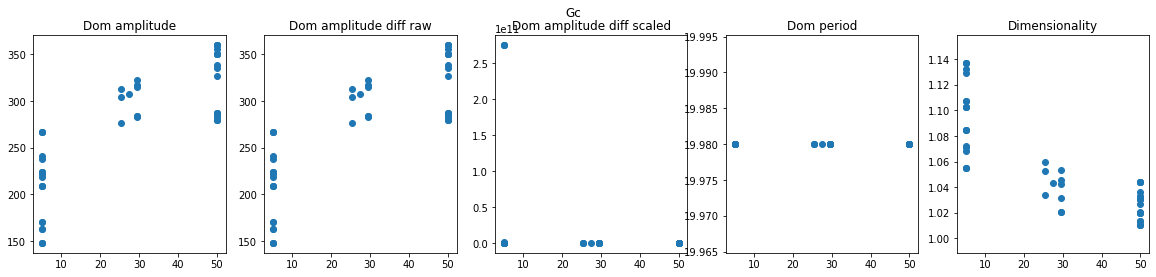

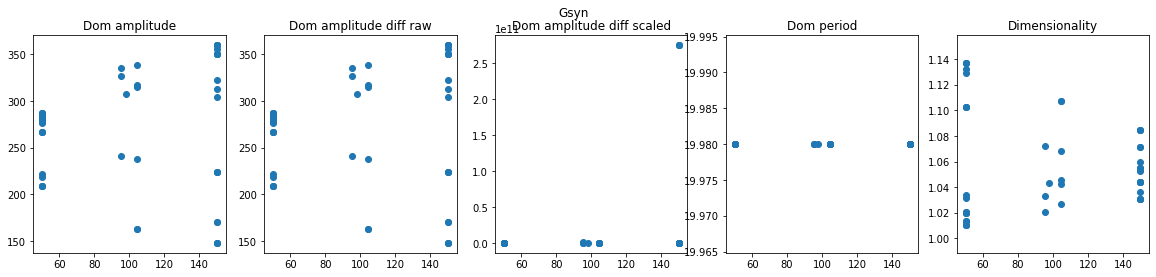

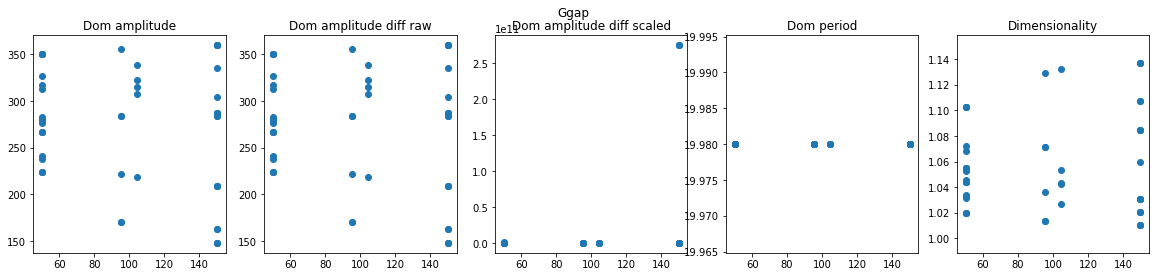

In [16]:
model_terms = model.split(" + ")

for term in model_terms[0:3]:
    param_vals = data[term]
    
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
    ax = axes[0]
    ax.scatter(param_vals, dom_amplitude)
    ax.set_title("Dom amplitude")
    ax = axes[1]
    ax.scatter(param_vals, dom_amplitude_diff_raw)
    ax.set_title("Dom amplitude diff raw")
    ax = axes[2]
    ax.scatter(param_vals, dom_amplitude_diff_scaled)
    ax.set_title("Dom amplitude diff scaled")
    ax = axes[3]
    ax.scatter(param_vals, dom_period)
    ax.set_title("Dom period")
    ax = axes[4]
    ax.scatter(param_vals, dimensionality)
    ax.set_title("Dimensionality")
    
    fig.suptitle(term) # or plt.suptitle('Main title')
    plt.show()
    

The variability we are seeing here in Gsyn and Ggap illustrates that variation in a single parameter does not cause change in the measured outputs. The interaction terms are important components of this model. Will need to look into how to illustrate these terms. Just at face value.. This indicates that Gc is a pretty significant term

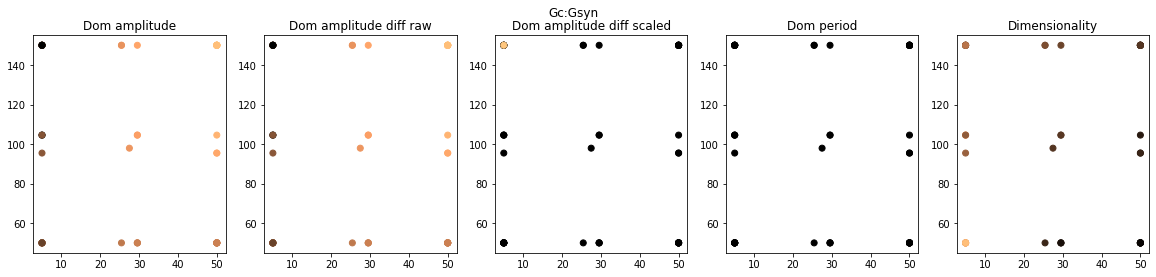

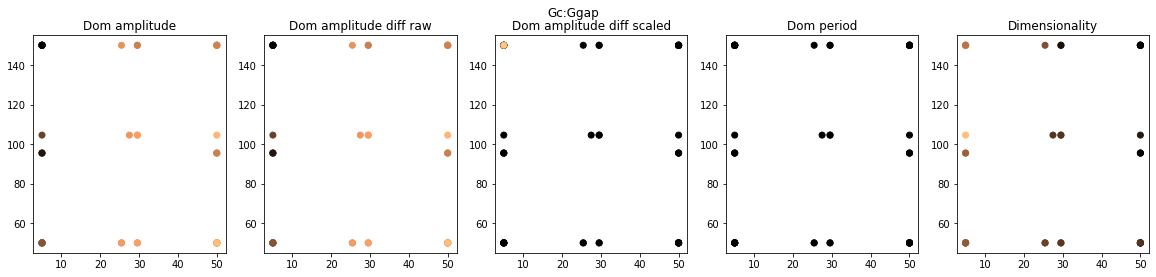

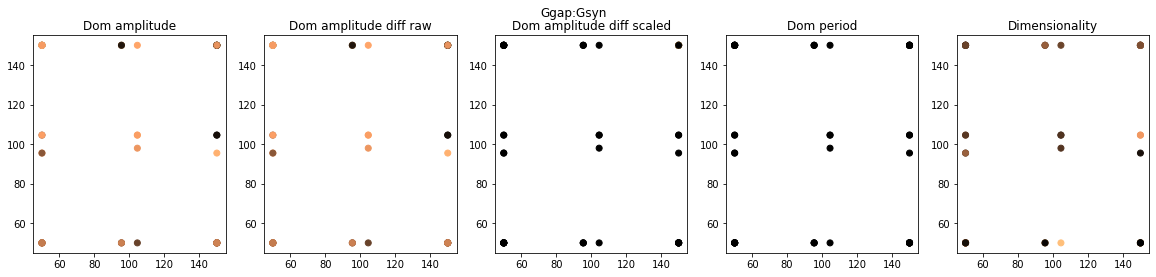

In [19]:
for term in model_terms[3:6]:
    parts = term.split(":")
    
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
    
    ax = axes[0]
    ax.scatter(data[parts[0]], data[parts[1]], c=dom_amplitude,  cmap="copper")
    ax.set_title("Dom amplitude")
    
    ax = axes[1]
    ax.scatter(data[parts[0]], data[parts[1]], c=dom_amplitude_diff_raw,  cmap="copper")
    ax.set_title("Dom amplitude diff raw")
    
    ax = axes[2]
    ax.scatter(data[parts[0]], data[parts[1]], c=dom_amplitude_diff_scaled,  cmap="copper")
    ax.set_title("Dom amplitude diff scaled")
    
    ax = axes[3]
    ax.scatter(data[parts[0]], data[parts[1]], c=dom_period,  cmap="copper")
    ax.set_title("Dom period")
    
    ax = axes[4]
    ax.scatter(data[parts[0]], data[parts[1]], c=dimensionality,  cmap="copper")
    ax.set_title("Dimensionality")
    
    fig.suptitle(term)
    plt.show()

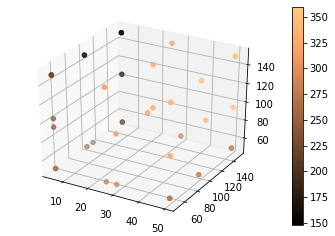

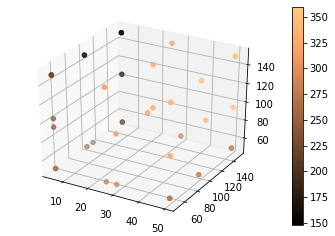

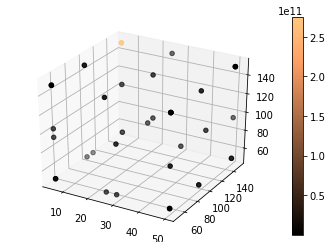

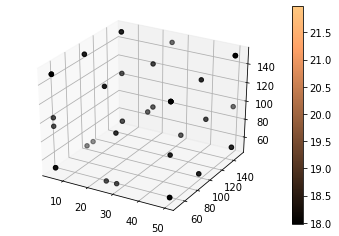

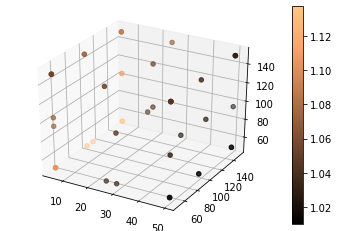

In [27]:
#Gc:Gsyn:Ggap interaction term visualized
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

outputs = list(data.columns)
outputs = outputs[3:]

for i in outputs:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = data['Gc']
    y = data['Ggap']
    z = data['Gsyn']
    c = data[i]

    img = ax.scatter(x, y, z, c=c, cmap="copper")
    fig.colorbar(img)
    plt.show()